## Helper functions & Example experiment

In [1]:
"""Imports"""
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

from cot import Collection
import yaml

In [2]:
# Helper functions to call OpenAI model, system also generates reasoning
def system_experiment(data,model, path_system_template):
    chat = ChatOpenAI(
        temperature=0,
        model_name=model,
        request_timeout=600,
        max_retries=1,
    )

    human_template="""Answer the question:{question}\nwith the following answer options:{answer_options}"""
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    
    with open(path_system_template, 'r') as file:
        template = file.read()
    system_message_prompt = SystemMessagePromptTemplate.from_template(template)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])  
    input_dict = {'chat':chat,'chat_prompt':chat_prompt} 
    
    return data.system_generate(input_dict)

def save_as_yaml(data, filepath):
    with open(filepath, 'w') as file:
        yaml.dump(data, file)

In [3]:
def system_evaluate(data,model, path_system_template):
    chat = ChatOpenAI(
        temperature=0,
        model_name=model,
        request_timeout=600,
        max_retries=1,
    )

    human_template="""Answer the question:{question}\n
    with the following answer options:{answer_options}\n
    Reasoning: {reasoning}\n
    Answer: {answer}"""
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    
    with open(path_system_template, 'r') as file:
        template = file.read()
    system_message_prompt = SystemMessagePromptTemplate.from_template(template)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])  
    input_dict = {'chat':chat,'chat_prompt':chat_prompt, "api_time_interval": 1} 
    
    return data.system_eval(input_dict)

In [4]:
#process new data old
import pandas as pd
import yaml

def process_new_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    for item in new_data[dataset][split]:
        try:
            scores_per_item.append(yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader))
        except:
            print("wrong output found")
            continue

    # Get unique keys from all dictionaries
    keys = set().union(*scores_per_item)

    # Create lists of values for each key
    scores_per_objective = {key: [d.get(key) for d in scores_per_item] for key in keys if key != "critique"} #added critique

    #check values for nonetype
    for key, value in scores_per_objective.items():
        if value is not str:
            print(key,value)


    # Calculate the average of each list
    averaged_data = {key: sum(value) / len(value) for key, value in scores_per_objective.items() if key!="critique"} #added critique

    # Convert the averaged data dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(averaged_data, orient='index', columns=['Average'])

    # Sort the DataFrame by the index (row labels)
    df = df.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11']]

    return scores_per_item, scores_per_objective, df

In [69]:
def parse_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    variables_per_item = []
    for item in new_data[dataset][split]:
        try:
            data = yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader)
            if any(isinstance(v, str) for v in data.values()):
                new_dict = {k: v for k, v in data.items() if k.startswith('obj')}
                scores_per_item.append(new_dict)
                variables_per_item.append(data)
            else:
                scores_per_item.append(data)
        except:
        
            print("wrong output found")
            continue
    return scores_per_item, variables_per_item

In [244]:
def parse_lst_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    variables_per_item = []
    statements_per_item = []
    for item in new_data[dataset][split]:
        try:
            data = yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader)
            #if any(isinstance(v, str) for v in data.values()):
            new_dict = {k: v[1] for k, v in data.items() if k.startswith('obj')}
            statement_dict = {k: v[0] for k, v in data.items() if k.startswith('obj')}
            statements_per_item.append(statement_dict)
            scores_per_item.append(new_dict)
            variables_per_item.append(data)
            # else:
            #     scores_per_item.append(data)
        except:
        
            print("wrong output found")
            continue
    return scores_per_item, variables_per_item, statements_per_item


In [ ]:
def get_further_data(scores_per_item):
# Get unique keys from all dictionaries
    keys = set().union(*scores_per_item)

    # Create lists of values for each key
    scores_per_objective = {key: [d.get(key) for d in scores_per_item] for key in keys}
    # scores_per_objective = {k: v for k, v in scores_per_objective.items() if not isinstance(v, str)}
    # print(scores_per_objective)

    # #check values for nonetype
    # for key, value in scores_per_objective.items():
    #     if value is not str:
    #         #print(key,value)
    #         continue


    # Calculate the average of each list
    #averaged_data = {key: sum(value) / len(value) for key, value in scores_per_objective.items()} 
    averaged_data = {key: (sum(v for v in value if v is not None) / len([v for v in value if v is not None])) for key, value in scores_per_objective.items() if len([v for v in value if v is not None]) > 0}

    # Convert the averaged data dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(averaged_data, orient='index', columns=['Average'])

    # Sort the DataFrame by the index (row labels)
    df = df.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11']]

    return scores_per_objective, df

In [87]:
def fix_none_score(scores_per_item):
    for i,element in enumerate(scores_per_item):
        for inner_key, value in element.items():
            if value is None:
                scores_per_item[i][inner_key] = 5
    return scores_per_item
    

In [97]:
def fix_str_score(scores_per_item):
    for i,element in enumerate(scores_per_item):
        for inner_key, value in element.items():
            if isinstance(value,str):
                scores_per_item.pop(i)
    return scores_per_item

In [ ]:
#helper functions for results
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import statistics

def freq_bar_plot(scores_per_item): #later better axes
    average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
    # Create a histogram
    plt.hist(average_per_item, bins='auto', alpha=0.7)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Frequency of average score per item')
    plt.show()

def avg_item_plot(scores_per_objective):  #later better axes
 
    data = scores_per_objective
    averaged_data = {key: sum(value) / len(value) for key, value in data.items() if key!="critique"} #added "critique"
    sorted_data = {k: v for k, v in sorted(averaged_data.items())}

    # Extract the keys (objectives) and values (averages) from the sorted dictionary
    keys = sorted_data.keys()
    values = sorted_data.values()

    # Create a bar plot
    plt.bar(keys, values)
    plt.xlabel('Objectives')
    plt.ylabel('Average')
    # plt.ylim(7,10)
    plt.title('Average per Objective')
    plt.xticks(rotation=45)
    plt.show()

def avg_true_false(data,average_per_item,dataset,split):
    item_correct = []
    for item in data[dataset][split]:
        item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

    # Example lists of scores and indicators
    scores = average_per_item
    indicators = item_correct

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    print("scores true:", statistics.mean(scores_true))
    print("scores false:", statistics.mean(scores_false))

## //

In [88]:
scores_per_item = fix_none_score(scores_per_item)

In [92]:
for i,element in enumerate(scores_per_item):
        for inner_key, value in element.items():
            if isinstance(value,str):
                print(element)

{'obj_1': 'The response accurately interprets the question and breaks it down.', 'obj_2': 'The response considers the relevant information but does not avoid considering irrelevant information.', 'obj_3': 'The response is sensitive to the numerical information provided by the user but does not incorporate it into the response.', 'obj_4': 'The response does not consider all relevant reasoning strategies and does not select the most appropriate reasoning strategy.', 'obj_5': 'The reasoning in the response is not structured at an appropriate level of detail.', 'obj_6': 'The response does not give appropriate priorities to different considerations based on their relevance and importance.', 'obj_7': 'The response does not list and consider all relevant underlying assumptions.', 'obj_8': 'The response is plausible, logically valid, sound, consistent, and coherent.', 'obj_9': 5, 'obj_10': 6, 'obj_11': 8, 'inner_key': 7}
{'obj_1': 'The response accurately interprets the question and breaks it 

In [70]:
data = Collection.from_json("medqa_cohere_template_20")

In [77]:
new_dict = scores_per_item
for i,inner_dict in enumerate(new_dict):
    for inner_key, value in inner_dict.items():
        if value is None:
            new_dict[i]['inner_key'] = 7

In [116]:
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
#scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)


In [8]:
#{k: v for k, v in test.items() if not isinstance(v, str)}
new_dict = {k: v for k, v in test.items() if not isinstance(v, str)}
new_dict

{'obj_1': 8,
 'obj_2': 9,
 'obj_3': 8,
 'obj_4': 8,
 'obj_5': 7,
 'obj_6': 8,
 'obj_7': 8,
 'obj_8': 9,
 'obj_9': 7,
 'obj_10': 8,
 'obj_11': 9}

In [9]:
any(isinstance(v, str) for v in new_dict.values())

False

In [10]:
any(isinstance(v, str) for v in test.values())

True

In [99]:
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)



In [106]:
med_qa = Collection.load_thoughtsource_100(names=['med_qa'],load_pregenerated_cots=True)

In [107]:
med_qa.number_generated_cots()

med_qa {32}


In [108]:
med_qa.select_generated_cots(
    model=[
        # 'gpt-3.5-turbo',
        'gpt-4',
        # 'flan-T5-xxl',
    ],
    cot_trigger=[
        # None, 
        'zhou-01'
    ],
    instruction=[
        None
    ]
    # answer= False
    )

In [111]:
med_qa.select_generated_cots(
    model=[
        # 'gpt-3.5-turbo',
        'gpt-4',
        # 'flan-T5-xxl',
    ]
    )

In [114]:
med_qa.select_generated_cots(
   
    cot_trigger=[
        # None, 
        'zhou-01']
    
    )

In [115]:
med_qa.number_generated_cots()

med_qa {1}


In [113]:
med_qa['med_qa']['test'][0]

{'id': 'med_qa_test_2',
 'ref_id': '',
 'question': 'Two weeks after undergoing an emergency cardiac catherization with stenting for unstable angina pectoris, a 61-year-old man has decreased urinary output and malaise. He has type 2 diabetes mellitus and osteoarthritis of the hips. Prior to admission, his medications were insulin and naproxen. He was also started on aspirin, clopidogrel, and metoprolol after the coronary intervention. His temperature is 38°C (100.4°F), pulse is 93/min, and blood pressure is 125/85 mm Hg. Examination shows mottled, reticulated purplish discoloration of the feet. Laboratory studies show:\nHemoglobin count 14 g/dL\nLeukocyte count 16,400/mm3\nSegmented neutrophils 56%\nEosinophils 11%\nLymphocytes 31%\nMonocytes 2%\nPlatelet count 260,000/mm3\nErythrocyte sedimentation rate 68 mm/h\nSerum\nUrea nitrogen 25 mg/dL\nCreatinine 4.2 mg/dL\nRenal biopsy shows intravascular spindle-shaped vacuoles. Which of the following is the most likely cause of this patient\

## GPT-3.5 evaluates itself with 3 different promps

In [86]:
med_zhou = Collection.from_json("med_qa_zhou_eval.json")


In [87]:
med_zhou

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    100 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [95]:
#for template 13 "There is room for improvement prompt"
absolute_path = "./reflection_messages/input_system/system_template_13_eval.yaml"
system_evaluate(med_zhou,'gpt-3.5-turbo',absolute_path)
med_zhou.dump("med_qa_template_13")
output = process_new_data(med_zhou,idx_cot=1)
print(output)

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 63: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID c6cc1cdfbeec9baabfe3f7008406cf6f in your message.)
Retrying with additional time of 10 seconds.
wrong output found
wrong output found
         Average
obj_1   9.122449
obj_2   9.836735
obj_3   9.000000
obj_4   9.500000
obj_5   8.836735
obj_6   9.295918
obj_7   9.234694
obj_8   9.724490
obj_9   8.918367
obj_10  9.285714
obj_11  9.683673


In [100]:
#template 12 "the average score of the objectives should usually be at most 7-8."
absolute_path = "./reflection_messages/input_system/system_template_12_eval.yaml"
system_evaluate(med_zhou,'gpt-3.5-turbo',absolute_path)
med_zhou.dump("med_qa_template_12")
output = process_new_data(med_zhou,idx_cot=1)
print(output)

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 88: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID d334e30cbc2755eaf79a8e06d350a18e in your message.)
Retrying with additional time of 10 seconds.


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

wrong output found
         Average
obj_1   8.242424
obj_2   9.141414
obj_3   8.202020
obj_4   8.747475
obj_5   7.787879
obj_6   8.141414
obj_7   8.252525
obj_8   9.070707
obj_9   7.757576
obj_10  8.141414
obj_11  9.000000


In [105]:
scores_per_item, scores_per_objective, df = process_new_data(med_zhou,idx_cot=1)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
print(average_per_item)

[8.272727272727273, 8.545454545454545, 8.181818181818182, 8.363636363636363, 8.363636363636363, 9.090909090909092, 8.363636363636363, 8.545454545454545, 8.272727272727273, 8.454545454545455, 8.363636363636363, 8.090909090909092, 9.090909090909092, 8.454545454545455, 8.363636363636363, 8.181818181818182, 8.363636363636363, 8.363636363636363, 8.272727272727273, 8.181818181818182, 8.363636363636363, 8.545454545454545, 8.545454545454545, 8.090909090909092, 8.181818181818182, 8.090909090909092, 8.363636363636363, 8.363636363636363, 8.545454545454545, 8.545454545454545, 8.545454545454545, 8.090909090909092, 8.545454545454545, 9.090909090909092, 8.181818181818182, 9.181818181818182, 7.545454545454546, 8.090909090909092, 8.636363636363637, 8.272727272727273, 8.363636363636363, 8.363636363636363, 8.363636363636363, 8.454545454545455, 8.363636363636363, 8.363636363636363, 8.363636363636363, 8.090909090909092, 8.272727272727273, 8.454545454545455, 9.272727272727273, 8.454545454545455, 8.0, 8.3636

In [ ]:
#for template 14 "Be critical: a higher variation in rating scores can lead to more insight."
med_zhou_14 = Collection.from_json("med_qa_zhou_eval.json")
absolute_path = "/Users/robertpraas/Desktop/ThoughtSource/notebooks/reflection_messages/input_system/system_template_14_eval.yaml"
system_evaluate(med_zhou_14,'gpt-3.5-turbo',absolute_path)
med_zhou.dump("med_qa_template_14") 
scores_per_item, scores_per_objective, df = process_new_data(med_zhou,idx_cot=1)

In [149]:
scores_per_item, scores_per_objective, df = process_new_data(med_zhou_14,idx_cot=1)

## GPT-4 correct GPT-3.5?

In [10]:
#create a balanced dataset

import copy
med_qa = Collection.from_json("/Users/robertpraas/Desktop/ThoughtSource/notebooks/reflection_messages/med_qa_zhou_eval_gpt4.json")
med_qa_correct = copy.deepcopy(med_qa)
med_qa_false = copy.deepcopy(med_qa)
med_qa_correct.select_generated_cots(answer=True)
med_qa_correct = med_qa_correct.filter(lambda x: len(x["generated_cot"])==1)

med_qa_false.select_generated_cots(answer=False)
med_qa_false = med_qa_false.filter(lambda x: len(x["generated_cot"])==1)

In [15]:
med_qa_correct = med_qa_correct.select(split="test", number_samples=19, random_samples=True, seed=0)
med_qa_correct.dump("medqa_correct_gpt_4_sample_of_19")
med_qa_correct

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |     19 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [ ]:
#Generate with template 14

absolute_path = "/Users/robertpraas/Desktop/ThoughtSource/notebooks/reflection_messages/input_system/system_template_14_eval.yaml"
system_evaluate(medqa_total,'gpt-4',absolute_path)
medqa_total.dump("med_qa_gpt_4_template_14") 
scores_per_item, scores_per_objective, df = process_new_data(medqa_total,idx_cot=1)


In [23]:
df

,Average
obj_1,10.000000
obj_2,9.710526
obj_3,9.973684
obj_4,9.736842
obj_5,9.947368
obj_6,9.710526
obj_7,8.710526
obj_8,10.000000
obj_9,9.131579
obj_10,9.973684


In [30]:
medqa_total = med_qa_false.merge(med_qa_correct)
medqa_total

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |     38 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [31]:
#Generate with template 12

absolute_path = "/Users/robertpraas/Desktop/ThoughtSource/notebooks/reflection_messages/input_system/system_template_12_eval.yaml"
system_evaluate(medqa_total,'gpt-4',absolute_path)
medqa_total.dump("med_qa_gpt_4_template_12") 
scores_per_item, scores_per_objective, df = process_new_data(medqa_total,idx_cot=1)


Generating med_qa...


  0%|          | 0/38 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [32]:
df


,Average
obj_1,10.000000
obj_2,9.447368
obj_3,10.000000
obj_4,9.394737
obj_5,9.789474
obj_6,9.447368
obj_7,8.368421
obj_8,9.973684
obj_9,8.868421
obj_10,9.842105


## Openbook, Medmc for gpt-3.5

In [ ]:
#template 12

ob_zhou_12 = Collection.from_json("openbook_zhou_eval_chatgpt.json")
absolute_path = "/Users/robertpraas/Desktop/ThoughtSource/notebooks/reflection_messages/input_system/system_template_12_eval.yaml"
system_evaluate(ob_zhou_12,'gpt-3.5-turbo',absolute_path)
ob_zhou_12.dump("ob_template_12_chatgpt")



In [25]:
ob_zhou_12 = Collection.from_json("ob_template_12_chatgpt")

In [ ]:
scores_per_item, scores_per_objective, df = process_new_data(ob_zhou_12,idx_cot=1,dataset='open_book_qa',split='test')

In [ ]:
#for template 14
from cot import Collection
ob_zhou_14 = Collection.from_json("openbook_zhou_eval_chatgpt.json")
absolute_path = "/Users/robertpraas/Desktop/ThoughtSource/notebooks/reflection_messages/input_system/system_template_14_eval.yaml"
system_evaluate(ob_zhou_14,'gpt-3.5-turbo',absolute_path)
ob_zhou_14.dump("ob_template_14_chatgpt") 


In [28]:
scores_per_item, scores_per_objective, df = process_new_data(ob_zhou_14,idx_cot=1,dataset='open_book_qa',split='test')

wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
obj_11 [10, 9, 10, 10, 10, 10, 10, 10, 10, 9, 10, 9, 10, 10, 10, 10, 10, 9, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1, 10, 9, 10, 10, 10, 10, 9, 10, 10, 9, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10]
obj_6 [9, 9, 9, 10, 10, 9, 10, 9, 9, 8, 10, 8, 10, 9, 9, 9, 8, 8, 10, 9, 10, 10, 10, 10, 10, 10, 10, 9, 9, 10, 10, 10, 10, 8, 9, 10, 9, 10, 9, 10, 9, 9, 10, 9, 10, 9, 10, 10, 9, 9, 9, 9, 10, 10, 9, 10, 10, 8, 9, 10, 9, 9, 10, 10, 10, 10, 10, 9, 10, 9, 9, 10, 8, 10, 10, 9, 9, 8, 10, 10, 8, 10, 10, 10, 9, 9, 10, 9, 10, 9, 10, 8, 10]
obj_4 [10, 9, 10, 10, 10, 10, 10, 10, 10, 8, 10, 8, 10, 10, 10, 10, 8, 7, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 9, 10, 10, 9, 10

         Average
obj_1   9.677419
obj_2   9.956989
obj_3   8.537634
obj_4   9.666667
obj_5   9.010753
obj_6   9.397849
obj_7   9.301075
obj_8   9.827957
obj_9   8.344086
obj_10  9.258065
obj_11  9.763441
scores true: 9.269972451790634
scores false: 9.511784511784512


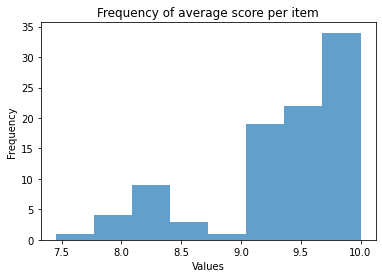

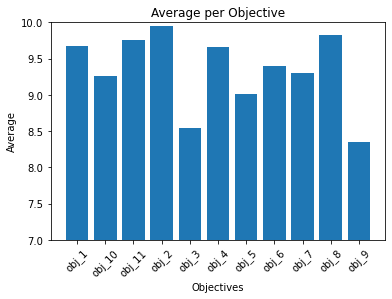

In [45]:
print(df)
avg_true_false(ob_zhou_14,'open_book_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

## Writing about statements makes AI more critical

In [94]:
#test for bigger dataset
from cot import Collection
cohere = Collection.from_json("./med_qa_zhou_cohere.json")
cohere.select_generated_cots(answer=False)
cohere_false = cohere.filter(lambda x: len(x["generated_cot"])==1)
cohere_false = cohere_false.select(split="test", number_samples=15, random_samples=True, seed=0)

cohere_false


| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |     15 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [100]:
absolute_path = "./input_system/system_template_15_eval.yaml"
system_evaluate(cohere_false,'gpt-3.5-turbo',absolute_path)

Generating med_qa...


In [102]:
cohere_false['med_qa']['test'][0]['generated_cot'][1]['cot']

"obj_1: The response accurately interprets the question and breaks it down by providing relevant information from the patient's history, examination, and investigations.\n- [9]\n\nobj_2: The response considers all relevant information and specifically avoids considering irrelevant information.\n- [9]\n\nobj_3: The response is sensitive to the numerical information provided by the user, accurately interpreting and incorporating it into the response by mentioning the patient's age and the fact that she had a similar episode affecting the opposite leg one year ago.\n- [8]\n\nobj_4: The response considers all relevant reasoning strategies and selects the most appropriate reasoning strategy by identifying the most likely pathophysiology of the patient's condition based on her history, examination, and investigations.\n- [9]\n\nobj_5: The reasoning in the response is structured at an appropriate level of detail by providing a clear and concise explanation of the most likely pathophysiology o

In [103]:
cohere_false.dump("cohere_false_check")

In [94]:
cohere_false = Collection.from_json("cohere_false_check")
cohere_false

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |     15 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [ ]:
# TEMPLATE 15

In [117]:
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)

         Average
obj_1   5.771739
obj_2   7.347826
obj_3   5.978261
obj_4   5.347826
obj_5   5.239130
obj_6   5.923913
obj_7   5.467391
obj_8   6.260870
obj_9   4.271739
obj_10  5.673913
obj_11  5.782609


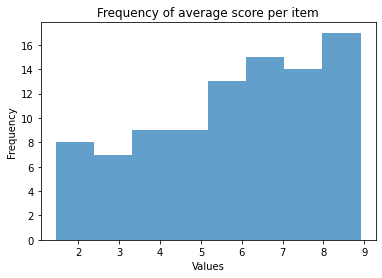

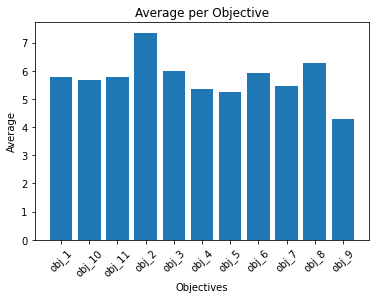

In [128]:
# parse yaml first
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
#avg_true_false(cohere_false,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

In [ ]:
#compare template 15 with 14, does it matter wether you write output?

In [129]:
absolute_path = "./input_system/system_template_14_eval.yaml"
system_evaluate(cohere_false,'gpt-3.5-turbo',absolute_path)


Generating med_qa...


In [132]:
#scores_per_item, scores_per_objective, df = process_new_data(med_co,idx_cot=2,dataset='med_qa',split='test')

scores_per_item, variables_per_item = parse_data(cohere_false,idx_cot=2,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)

         Average
obj_1   9.066667
obj_2   9.600000
obj_3   8.066667
obj_4   9.000000
obj_5   7.933333
obj_6   8.733333
obj_7   8.733333
obj_8   9.466667
obj_9   7.933333
obj_10  8.866667
obj_11  9.533333


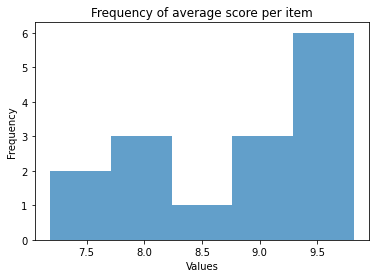

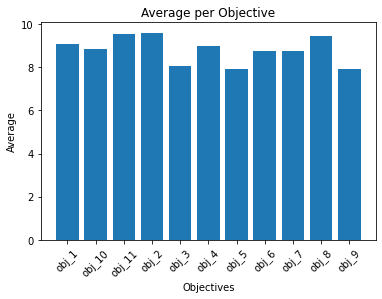

In [133]:
# parse yaml first
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

In [ ]:
#Now test if giving a legend works as well

In [134]:
absolute_path = "./input_system/system_template_18.yaml"
system_evaluate(cohere_false,'gpt-3.5-turbo',absolute_path)
cohere_false.dump("medqa_cohere_template_15_14_18")

Generating med_qa...


In [135]:
scores_per_item, variables_per_item = parse_data(cohere_false,idx_cot=3,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)

         Average
obj_1   8.600000
obj_2   9.266667
obj_3   7.733333
obj_4   8.400000
obj_5   7.333333
obj_6   8.066667
obj_7   7.600000
obj_8   8.933333
obj_9   7.466667
obj_10  8.333333
obj_11  9.333333


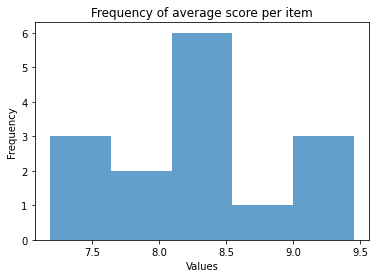

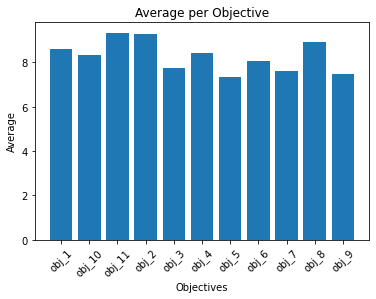

In [136]:
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

In [137]:
#template 15 +18 -> 22 """Does not seem to work and rather confuse"""
absolute_path = "./input_system/system_template_22.yaml"
system_evaluate(cohere_false,'gpt-3.5-turbo',absolute_path)
cohere_false.dump("medqa_cohere_template_15_14_18_22")

Generating med_qa...


In [148]:
cohere_false['med_qa']['test'][0]['generated_cot'][4]['cot']

"obj_1: The response accurately interprets the question and breaks it down by providing relevant information from the patient's history and examination.\n- Good\nobj_2: The response considers all relevant information and specifically avoids considering irrelevant information.\n- Good\nobj_3: The response is sensitive to the numerical information provided by the user and accurately incorporates it into the response by mentioning the patient's history of thrombus in the right femoral vein and a genetic workup revealing an inherited condition.\n- Good\nobj_4: The response considers all relevant reasoning strategies and selects the most appropriate reasoning strategy by identifying protein C deficiency as a natural anticoagulant.\n- Good\nobj_5: The reasoning in the response is structured at an appropriate level of detail by providing a clear explanation of the patient's condition and the role of protein C deficiency in it.\n- Good\nobj_6: The response gives appropriate priorities to diffe

In [ ]:
"""many wrong outputs"""
scores_per_item, variables_per_item = parse_data(cohere_false,idx_cot=4,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)

In [ ]:
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

In [149]:
absolute_path = "./input_system/system_template_20.yaml"
system_evaluate(cohere_false,'gpt-3.5-turbo',absolute_path)


Generating med_qa...


In [150]:
scores_per_item, variables_per_item = parse_data(cohere_false,idx_cot=5,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)

         Average
obj_1   6.400000
obj_2   8.066667
obj_3   6.266667
obj_4   6.066667
obj_5   5.466667
obj_6   6.400000
obj_7   5.800000
obj_8   6.733333
obj_9   4.866667
obj_10  6.333333
obj_11  6.400000


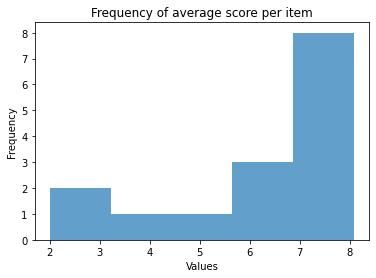

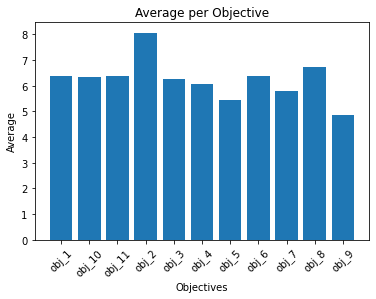

In [151]:
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

## GPT-4 assess GPT-3.5

In [76]:
data = Collection.from_json("med_qa_zhou_eval.json")
data = data.select(split="test", number_samples=5, random_samples=True, seed=0)
data


| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |      5 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [ ]:
absolute_path = "./input_system/system_template_14_eval.yaml"
system_evaluate(data,'gpt-4',absolute_path)
# medqa_total.dump("med_qa_gpt_4_template_12") 


In [79]:
scores_per_item, scores_per_objective, df = process_new_data(data,idx_cot=1,dataset='med_qa',split='test')

obj_11 [10, 6, 10, 10, 10]
obj_6 [10, 8, 9, 8, 10]
obj_4 [10, 8, 9, 8, 10]
obj_9 [9, 7, 9, 7, 9]
obj_2 [10, 8, 9, 8, 10]
obj_3 [10, 8, 10, 10, 10]
obj_10 [10, 9, 10, 9, 10]
obj_5 [10, 9, 9, 9, 10]
obj_8 [10, 8, 10, 9, 10]
obj_7 [9, 7, 8, 7, 9]
obj_1 [10, 9, 10, 9, 10]


In [80]:
data.dump("test_gpt4_on_3_14")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [74]:
absolute_path = "./input_system/system_template_12_eval.yaml"
system_evaluate(data,'gpt-4',absolute_path)
# medqa_total.dump("med_qa_gpt_4_template_12") 
scores_per_item, scores_per_objective, df = process_new_data(medqa_total,idx_cot=1)

Generating med_qa...


  0%|          | 0/1 [00:00<?, ?ex/s]

In [75]:
data['med_qa']['test'][0]['generated_cot'][2]['cot']

'obj_1: 10\nobj_2: 9\nobj_3: 10\nobj_4: 9\nobj_5: 9\nobj_6: 9\nobj_7: 8\nobj_8: 9\nobj_9: 9\nobj_10: 9\nobj_11: 10'

In [ ]:
absolute_path = "./input_system/system_template_16_eval.yaml"
system_evaluate(med_zhou,'gpt-3.5-turbo',absolute_path)

In [ ]:
#new

In [142]:
data = Collection.from_json("medqa_false_gpt_4.json")
absolute_path = "./input_system/system_template_20.yaml"
data = data.select(split="test", number_samples=10, random_samples=True, seed=0)
system_evaluate(data,'gpt-4',absolute_path)
data.dump("gpt_4_false_critique")

Generating med_qa...


  0%|          | 0/10 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [152]:
data = Collection.from_json("gpt_4_false_critique")

        Average
obj_1       9.7
obj_2       8.7
obj_3       9.9
obj_4       8.9
obj_5       9.4
obj_6       8.6
obj_7       7.9
obj_8       9.2
obj_9       8.3
obj_10      8.9
obj_11      9.6


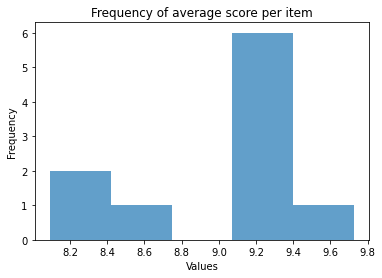

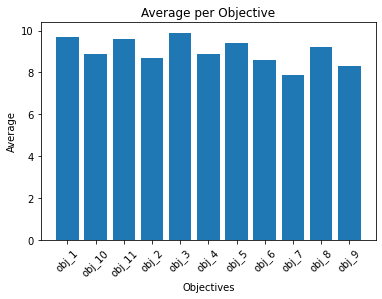

In [155]:
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
#avg_true_false(cohere_false,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

In [157]:
absolute_path = "./input_system/system_template_15_eval.yaml"
system_evaluate(data,'gpt-4',absolute_path)

Generating med_qa...


  0%|          | 0/10 [00:00<?, ?ex/s]

(API-)Error in item 9: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Tue, 30 May 2023 14:15:39 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7cf78daebd53c2e6-VIE', 'alt-svc': 'h3=":443"; ma=86400'}
Retrying with additional time of 10 seconds.


In [167]:
scores_per_item[7]

{'obj_1': ['Accurately interprets the question and breaks it down into relevant steps.',
  10],
 'obj_2': ['Considers all relevant information and avoids irrelevant information.',
  10],
 'obj_3': ['N/A (no numerical information provided)', 'N/A'],
 'obj_4': ['Considers the lymphatic route and selects the most appropriate reasoning strategy.',
  10],
 'obj_5': ['Reasoning is structured through steps and provides an appropriate level of detail.',
  10],
 'obj_6': ['Gives appropriate priorities to different considerations based on their relevance and importance.',
  10],
 'obj_7': ["Considers relevant underlying assumptions, such as the patient's ethnicity and the location of the sentinel nodes.",
  10],
 'obj_8': ['The response is plausible, logically valid, sound, consistent, and coherent.',
  10],
 'obj_9': ['Statements are supported by the reasoning provided, but no external evidence is referenced.',
  7],
 'obj_10': ['Contains accurate and relevant information, but could be more eng

In [158]:
data.dump("gpt_4_false_critique_20_15")
scores_per_item, variables_per_item = parse_data(data,idx_cot=2,dataset='med_qa',split='test')
#scores_per_item = fix_str_score(scores_per_item)

scores_per_objective, df = get_further_data(scores_per_item)
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
#avg_true_false(cohere_false,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

wrong output found
wrong output found


TypeError: unsupported operand type(s) for +: 'int' and 'list'

## 3.5 corrects Cohere: shows 12,14,16 does not work

In [22]:
from cot import Collection
med_co = Collection.from_json("med_qa_zhou_cohere.json")
#med_co = med_co.select(split="test", number_samples=1, random_samples=True, seed=0)


In [23]:
med_co

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    100 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [24]:
absolute_path = "./input_system/system_template_14_eval.yaml"
system_evaluate(med_co,'gpt-3.5-turbo',absolute_path)
med_co.dump("chatgpt_judges_cohere")

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 30: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 2b797b87820009fba581ccdd214e8a7c in your message.)
Retrying with additional time of 10 seconds.


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [26]:
scores_per_item, scores_per_objective, df = process_new_data(med_co,idx_cot=1,dataset='med_qa',split='test')


wrong output found
wrong output found
wrong output found
obj_4 [10, 9, 8, 10, 10, 10, 10, 9, 10, 10, 10, 9, 10, 8, 8, 8, 10, 7, 10, 10, 9, 8, 10, 10, 4, 10, 7, 8, 9, 10, 10, 10, 7, 8, 8, 6, 8, 4, 8, 6, 8, 9, 6, 8, 10, 10, 8, 10, 10, 10, 5, 8, 10, 9, 10, 9, 10, 8, 8, 10, 10, 8, 10, 8, 10, 10, 7, 10, 6, 8, 10, 10, 10, 8, 10, 8, 10, 6, 9, 8, 10, 8, 10, 10, 9, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 10, 7]
obj_8 [10, 9, 9, 10, 10, 10, 10, 9, 10, 10, 10, 9, 10, 9, 9, 9, 10, 8, 10, 10, 9, 9, 10, 10, 6, 10, 8, 9, 10, 10, 10, 10, 7, 9, 9, 8, 8, 4, 8, 8, 8, 9, 8, 9, 10, 10, 9, 10, 10, 10, 6, 9, 10, 9, 10, 9, 10, 9, 9, 10, 10, 9, 10, 9, 10, 10, 8, 10, 8, 8, 10, 10, 10, 9, 10, 9, 10, 8, 9, 8, 10, 9, 10, 10, 9, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 10, 8]
obj_2 [10, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 9, 9, 9, 10, 9, 10, 10, 9, 9, 10, 10, 9, 10, 9, 9, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 9, 10, 10, 10, 9, 10, 10, 9, 10, 9, 10, 10, 9, 10, 10, 9, 10, 9, 10, 10, 9, 10,

         Average
obj_1   9.030928
obj_2   9.556701
obj_3   8.061856
obj_4   8.865979
obj_5   7.948454
obj_6   8.690722
obj_7   8.628866
obj_8   9.237113
obj_9   7.927835
obj_10  8.680412
obj_11  9.298969
scores true: 8.733333333333333
scores false: 8.71506105834464


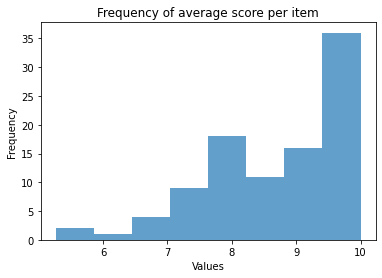

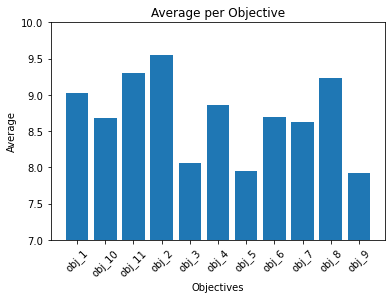

In [30]:
# This way ChatGPT does not correct cohere in anyway, need to ask it to dig deeper/more concrete
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
avg_true_false(med_co,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

In [39]:
from cot import Collection
med_co = Collection.from_json("med_qa_zhou_cohere.json")
# med_co = med_co.select(split="test", number_samples=5, random_samples=True, seed=0)


In [32]:
absolute_path = "./input_system/system_template_16_improve.yaml"
system_evaluate(med_co,'gpt-3.5-turbo',absolute_path)


Generating med_qa...


  0%|          | 0/5 [00:00<?, ?ex/s]

In [33]:
med_co.dump("correction_test")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [40]:
med_co.evaluate()

  0%|          | 0/100 [00:00<?, ?ex/s]

{'med_qa': {'test': {'accuracy': {'command-xlarge-nightly': {'None_zhou-01_kojima-A-E': 0.32}}}}}

In [36]:
med_co.select_generated_cots(answer=False)
med_co_false = med_co.filter(lambda x: len(x["generated_cot"])==1)

In [37]:
med_co_false

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |     68 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [41]:
absolute_path = "./input_system/system_template_16_improve.yaml"
system_evaluate(med_co,'gpt-3.5-turbo',absolute_path)

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 3: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID ec4033ca79513c56921a4c5a91dde67e in your message.)
Retrying with additional time of 10 seconds.
(API-)Error in item 17: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 83d987a460cff5dcda0bf041d64a3c64 in your message.)
Retrying with additional time of 10 seconds.


In [42]:
med_co.dump("full_chatgpt_cohere_correction")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [43]:
absolute_path = "./input_system/system_template_16_improve.yaml"
system_evaluate(med_co,'gpt-4',absolute_path)

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 31: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID f7933b7535f23c4a9629ef0929a6e0ba in your message.)
Retrying with additional time of 10 seconds.
(API-)Error in item 60: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID d91af4f8bc51adbb8c70853969ebf927 in your message.)
Retrying with additional time of 10 seconds.
(API-)Error in item 94: HTTP code 502 from API (<html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>cloudflare</center>
</body>
</html>
)
Retrying with additional time of 10 seconds.


In [44]:
med_co.dump("gpt_3_4_cohere_correction")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [48]:
med_co['med_qa']['test'][0]

{'id': 'med_qa_test_2',
 'ref_id': '',
 'question': 'Two weeks after undergoing an emergency cardiac catherization with stenting for unstable angina pectoris, a 61-year-old man has decreased urinary output and malaise. He has type 2 diabetes mellitus and osteoarthritis of the hips. Prior to admission, his medications were insulin and naproxen. He was also started on aspirin, clopidogrel, and metoprolol after the coronary intervention. His temperature is 38°C (100.4°F), pulse is 93/min, and blood pressure is 125/85 mm Hg. Examination shows mottled, reticulated purplish discoloration of the feet. Laboratory studies show:\nHemoglobin count 14 g/dL\nLeukocyte count 16,400/mm3\nSegmented neutrophils 56%\nEosinophils 11%\nLymphocytes 31%\nMonocytes 2%\nPlatelet count 260,000/mm3\nErythrocyte sedimentation rate 68 mm/h\nSerum\nUrea nitrogen 25 mg/dL\nCreatinine 4.2 mg/dL\nRenal biopsy shows intravascular spindle-shaped vacuoles. Which of the following is the most likely cause of this patient\

In [89]:
med_co = Collection.from_json("gpt_3_4_cohere_correction")

In [90]:
import yaml
import re
count = 0
for j,element in enumerate(med_co['med_qa']['test']):
    for i in range(1,3):
        yaml_content = element['generated_cot'][i]['cot']
        try:
        #print(yaml_content)
            yaml_data = yaml.load(yaml_content, Loader=yaml.FullLoader)
            final_answer = yaml_data['final_answer']
            cot = yaml_data['corrected_reasoning']
            element['generated_cot'][i]['cot'] = cot
            element['generated_cot'][i]['answers'][0]['answer'] = final_answer   
        except:
            try:
                yaml_content = yaml_content.replace("corrected_reasoning: \n", "corrected_reasoning: ")
                #yaml_content = re.sub(r'([^:\n]+):\n', r'\n\1: ', yaml_content)
                yaml_data = yaml.load(yaml_content, Loader=yaml.FullLoader)
                final_answer = yaml_data['final_answer']
                cot = yaml_data['corrected_reasoning']
                element['generated_cot'][i]['cot'] = cot
                element['generated_cot'][i]['answers'][0]['answer'] = final_answer
                med_co['med_qa']['test'][j] = element
            except:
                print(i)
                print("wrong output found")
                # print(yaml_content)
                count +=1
                continue
    med_co['med_qa']['test'][j] = element
print(count)
med_co.evaluate()    
        






        #     yaml_content = yaml_content.replace('\n', ' ')
        #     try:
        #         yaml_data = yaml.load(yaml_content, Loader=yaml.FullLoader)
        #         final_answer = yaml_data['final_answer']
        #         cot = yaml_data['corrected_reasoning']
        #         element['generated_cot'][i]['cot'] = cot
        #         element['generated_cot'][i]['answers'][0]['answer'] = final_answer
        #     except:
        #         print("wrong output found")
        #         print(yaml_content)
        #         count +=1
        #         continue
        #yaml_data = yaml.safe_load(yaml_content)





# import yaml

# # Assuming the YAML content is stored in a string variable called 'yaml_content'
# yaml_data = yaml.safe_load(yaml_content)

# # Extracting the final_answer
# final_answer = yaml_data['final_answer']

1
wrong output found


TypeError: 'Dataset' object does not support item assignment

In [ ]:
#this does not work - write data.map function

In [88]:
len(med_co['med_qa']['test'][99])

10

In [76]:
str = """corrected_reasoning: 
The given reasoning is correct.

final_answer: C."""
str = str.replace("corrected_reasoning: \n", "corrected_reasoning: ")
yaml_data = yaml.load(str, Loader=yaml.FullLoader)
yaml_data['final_answer']

'C.'

In [ ]:
#####

In [9]:
absolute_path = "./input_system/system_template_12_eval.yaml"
system_evaluate(med_co,'gpt-3.5-turbo',absolute_path)

Generating med_qa...


In [10]:
absolute_path = "./input_system/system_template_16_eval.yaml"
system_evaluate(med_co,'gpt-3.5-turbo',absolute_path)

Generating med_qa...
(API-)Error in item 0: HTTP code 502 from API (<html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>cloudflare</center>
</body>
</html>
)
Retrying with additional time of 10 seconds.


In [16]:
absolute_path = "./input_system/system_template_17.yaml"
system_evaluate(med_co,'gpt-3.5-turbo',absolute_path)

Generating med_qa...


In [21]:
med_co['med_qa']['test'][0]['generated_cot'][1]['cot']

'obj_1: 8\nobj_2: 10\nobj_3: 8\nobj_4: 8\nobj_5: 7\nobj_6: 8\nobj_7: 8\nobj_8: 9\nobj_9: 7\nobj_10: 8\nobj_11: 10'

In [ ]:
scores_per_item, scores_per_objective, df = process_new_data(data,idx_cot=1,dataset='med_qa',split='test')

## more 3.5, 4 correct cohere

In [110]:
"""Write a short critique really important for contexts - """
#this was gpt-3.5, can still try gpt-4

data = Collection.from_json("med_qa_zhou_cohere.json")
absolute_path = "./input_system/system_template_20.yaml"
system_evaluate(data,'gpt-3.5-turbo',absolute_path)
data.dump("medqa_cohere_template_20")





Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 4: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 3eacec5e4f6e3ca5d027c7fbcf1ec33a in your message.)
Retrying with additional time of 10 seconds.


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

         Average
obj_1   5.771739
obj_2   7.347826
obj_3   5.978261
obj_4   5.347826
obj_5   5.239130
obj_6   5.923913
obj_7   5.467391
obj_8   6.260870
obj_9   4.271739
obj_10  5.673913
obj_11  5.782609


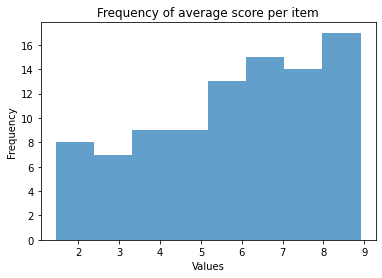

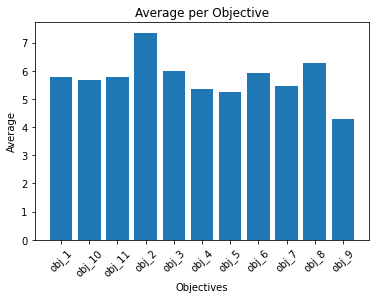

In [170]:
data = Collection.from_json("medqa_cohere_template_20")
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
#avg_true_false(cohere_false,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

In [111]:
#GPT-4 really helps cohere
#Can cohere learn from GPT-4 and change it?

data = Collection.from_json("med_qa_zhou_cohere.json")
data = data.select(split="test", number_samples=30, random_samples=True, seed=0)
system_evaluate(data,'gpt-4',absolute_path)
data.dump("medqa_cohere_template_20_gpt_4")

Generating med_qa...


  0%|          | 0/30 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

obj_4 [7, 4, 10, 3, 7, 3, 3, 8, 4, 2, 4, 5, 5, 9, 2, 5, 5, 5, 8, 4, 6, 4, 4, 6, 4, 6, 6, 7, 3, 8]
obj_8 [9, 3, 10, 3, 8, 3, 3, 9, 4, 2, 5, 6, 6, 9, 1, 5, 3, 6, 9, 3, 7, 4, 3, 6, 4, 3, 6, 8, 3, 9]
obj_2 [7, 5, 10, 4, 7, 4, 3, 8, 4, 3, 4, 5, 5, 8, 2, 5, 5, 5, 9, 4, 6, 7, 5, 6, 5, 6, 5, 7, 4, 7]
obj_6 [8, 5, 10, 4, 8, 4, 2, 8, 4, 3, 4, 5, 6, 8, 2, 5, 6, 5, 8, 5, 6, 7, 5, 6, 5, 6, 6, 8, 4, 7]
obj_9 [10, 1, 9, 2, 6, 3, 1, 7, 3, 1, 3, 6, 5, 7, 1, 4, 4, 6, 8, 3, 6, 6, 5, 5, 3, 6, 6, 7, 3, 7]
obj_3 [10, 7, 10, 6, 10, 6, 1, 10, 6, 6, 6, 7, 8, 10, 1, 6, 10, 8, 10, 6, 10, 10, 7, 5, 8, 10, 6, 10, 6, 10]
obj_5 [8, 2, 9, 3, 6, 4, 2, 7, 4, 3, 4, 6, 4, 7, 1, 5, 6, 6, 7, 5, 7, 6, 6, 6, 4, 6, 6, 7, 5, 7]
obj_1 [10, 9, 10, 8, 9, 8, 5, 10, 8, 5, 7, 9, 9, 9, 5, 8, 10, 9, 9, 7, 9, 9, 9, 7, 7, 10, 7, 9, 8, 10]
obj_10 [10, 4, 10, 4, 7, 5, 3, 8, 5, 2, 5, 7, 7, 9, 2, 6, 4, 7, 9, 4, 8, 8, 6, 6, 6, 6, 6, 8, 4, 8]
obj_7 [8, 5, 8, 5, 6, 5, 2, 7, 3, 3, 3, 6, 5, 7, 2, 5, 7, 6, 8, 5, 7, 7, 6, 5, 3, 7, 4, 6, 5, 7]
obj_

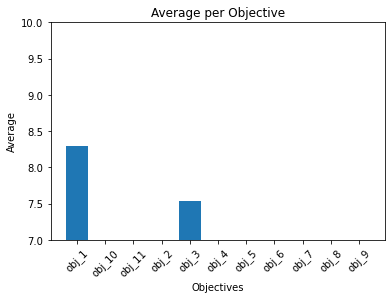

In [140]:
scores_per_item, scores_per_objective, df = process_new_data(test,idx_cot=1,dataset='med_qa',split='test')
print(df)
#average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

#values are summed within dict
#average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
average_per_item = [sum(v for v in d.values() if isinstance(v, int)) / len([v for v in d.values() if isinstance(v, int)]) for d in scores_per_item]
#.items()
avg_true_false(test,average_per_item,'med_qa','test')
#freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

In [138]:
scores_per_item[0]

{'critique': 'The response accurately interprets the question and provides a clear and concise reasoning for the answer. However, it only considers two of the answer options in the reasoning, leaving out the other three options.',
 'obj_1': 10,
 'obj_2': 7,
 'obj_3': 10,
 'obj_4': 7,
 'obj_5': 8,
 'obj_6': 8,
 'obj_7': 8,
 'obj_8': 9,
 'obj_9': 10,
 'obj_10': 10,
 'obj_11': 10}

## Still need to look at this data

In [112]:
data_1 = Collection.from_json("med_qa_zhou_cohere.json")
data_2 = Collection.from_json("openbook_zhou_eval_chatgpt.json")

absolute_path = "./input_system/system_template_18.yaml"
system_evaluate(data_1,'gpt-3.5-turbo',absolute_path)
data_1.dump("medqa_cohere_template_18")

system_evaluate(data_2,'gpt-3.5-turbo',absolute_path)
data_2.dump("ob_template_18")

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Generating open_book_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 87: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 22e93d4630dee62e8b3c85e4df998b48 in your message.)
Retrying with additional time of 10 seconds.
(API-)Error in item 99: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID a1dc321a84ea4d1226e2241477ed1497 in your message.)
Retrying with additional time of 10 seconds.


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [113]:
data = Collection.from_json("med_qa_zhou_cohere.json")
absolute_path = "./input_system/system_template_21.yaml"
system_evaluate(data,'gpt-3.5-turbo',absolute_path)
data.dump("medqa_cohere_template_21")

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 16: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 34d1ae31deb0db81b693b398113be3bb in your message.)
Retrying with additional time of 10 seconds.
(API-)Error in item 24: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 69a4d35e82daaeb8e3e7114def4d8d9c in your message.)
Retrying with additional time of 10 seconds.
(API-)Error in item 35: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 04b1fe586beabd4858c64aec195df8ff in your message.)
Retrying with additional time of 10 seconds.
(API-)Error in item 57: That model is currently overloa

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [114]:
data = Collection.from_json("med_qa_zhou_cohere.json")
data = data.select(split="test", number_samples=30, random_samples=True, seed=0)
system_evaluate(data,'gpt-4',absolute_path)
data.dump("medqa_cohere_template_21_gpt_4")


Generating med_qa...


  0%|          | 0/30 [00:00<?, ?ex/s]

(API-)Error in item 24: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Tue, 30 May 2023 00:11:05 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7cf2c1d59abec22b-VIE'}
Retrying with additional time of 10 seconds.
(API-)Error in item 27: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Tue, 30 May 2023 00:13:43 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection':

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [119]:
absolute_path = "./input_system/system_template_18.yaml"
system_evaluate(data_1,'gpt-4',absolute_path)
data_1.dump("medqa_cohere_template_18_gpt4")


Generating med_qa...


  0%|          | 0/30 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [131]:
#chatgpt
scores_per_item, scores_per_objective, df = process_new_data(data_1,idx_cot=1,dataset='med_qa',split='test')
print(df)
average_per_item = [sum(d.values()) / len(d) for k,d in scores_per_item.items() if k!="critique"]
# average_per_item = [sum(d.values()) / len(d) for k,d in scores_per_item if k!="critique"]
avg_true_false(data_1,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

obj_4 [9, 8, 10, 6, 8, 8, 7, 8, 7, 5, 8, 9, 9, 9, 6, 8, 8, 8, 9, 10, 8, 8, 8, 9, 8, 8, 5, 8, 8, 10]
obj_8 [9, 9, 10, 8, 9, 9, 8, 9, 8, 7, 9, 9, 9, 9, 7, 9, 9, 8, 9, 10, 9, 9, 9, 9, 9, 9, 8, 9, 9, 10]
obj_2 [9, 9, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 9, 9, 9, 9, 9, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10]
obj_6 [8, 8, 9, 7, 8, 8, 7, 8, 7, 6, 8, 8, 8, 9, 7, 8, 8, 8, 8, 9, 7, 7, 7, 8, 8, 8, 7, 8, 8, 9]
obj_9 [8, 7, 8, 5, 8, 7, 5, 8, 5, 3, 7, 8, 8, 8, 3, 7, 8, 7, 8, 9, 8, 6, 6, 8, 8, 7, 1, 8, 8, 9]
obj_3 [8, 7, 9, 7, 8, 7, 7, 8, 7, 6, 7, 8, 7, 8, 5, 7, 7, 7, 8, 9, 7, 6, 7, 8, 8, 8, 1, 8, 7, 9]
obj_5 [8, 7, 8, 6, 7, 7, 6, 7, 6, 4, 7, 8, 8, 8, 4, 7, 7, 7, 8, 8, 7, 7, 6, 8, 7, 7, 4, 7, 7, 9]
obj_1 [9, 8, 10, 8, 9, 8, 8, 8, 8, 8, 8, 9, 8, 10, 8, 8, 8, 8, 9, 10, 8, 8, 8, 9, 9, 9, 8, 9, 8, 10]
obj_10 [8, 8, 9, 7, 9, 8, 6, 8, 7, 6, 8, 8, 8, 9, 5, 8, 8, 8, 9, 10, 8, 8, 7, 8, 9, 8, 6, 8, 8, 10]
obj_7 [8, 8, 9, 6, 8, 8, 6, 7, 6, 5, 7, 8, 8, 9, 6, 8, 8, 7, 8, 9, 7, 8, 6, 8, 8, 8, 6, 8, 8, 9]
obj_11 [9, 9,

AttributeError: 'list' object has no attribute 'items'

obj_4 [10, 6, 10, 6, 8, 6, 3, 10, 6, 6, 7, 8, 8, 9, 3, 7, 7, 7, 8, 7, 9, 7, 7, 8, 8, 7, 8, 9, 7, 9]
obj_8 [10, 6, 10, 6, 9, 6, 3, 10, 6, 6, 8, 9, 9, 9, 3, 8, 7, 8, 9, 7, 10, 9, 7, 9, 8, 7, 9, 9, 7, 10]
obj_2 [10, 6, 10, 6, 8, 6, 4, 10, 6, 6, 8, 8, 8, 9, 3, 8, 7, 7, 8, 7, 9, 9, 7, 8, 8, 8, 8, 9, 6, 9]
obj_6 [10, 7, 10, 6, 8, 7, 3, 10, 6, 6, 8, 8, 8, 9, 3, 8, 8, 7, 8, 7, 9, 9, 7, 8, 8, 8, 8, 9, 7, 9]
obj_9 [9, 5, 9, 5, 7, 5, 1, 9, 5, 5, 6, 7, 7, 7, 1, 5, 6, 6, 7, 6, 8, 6, 5, 7, 7, 6, 7, 8, 5, 8]
obj_3 [10, 9, 10, 8, 10, 9, 1, 10, 5, 7, 9, 8, 9, 10, 1, 10, 9, 9, 9, 9, 10, 10, 6, 9, 9, 6, 10, 10, 8, 10]
obj_5 [9, 7, 9, 6, 8, 7, 2, 9, 6, 6, 7, 8, 8, 9, 2, 7, 7, 7, 8, 7, 9, 7, 7, 8, 8, 7, 8, 9, 7, 9]
obj_1 [10, 8, 10, 7, 9, 7, 5, 10, 7, 6, 9, 9, 9, 10, 3, 9, 8, 8, 9, 8, 10, 8, 8, 9, 9, 7, 9, 10, 7, 10]
obj_10 [10, 7, 10, 7, 9, 7, 3, 10, 6, 6, 8, 9, 9, 9, 3, 8, 8, 8, 8, 7, 10, 9, 7, 9, 8, 8, 9, 10, 7, 9]
obj_7 [9, 6, 9, 5, 7, 5, 2, 9, 5, 5, 7, 7, 7, 8, 3, 6, 6, 6, 7, 6, 8, 8, 6, 7, 7, 6, 7, 8

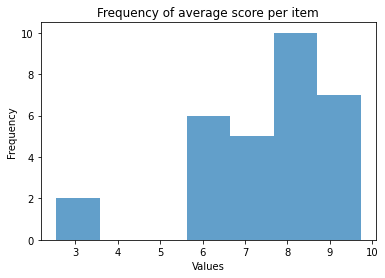

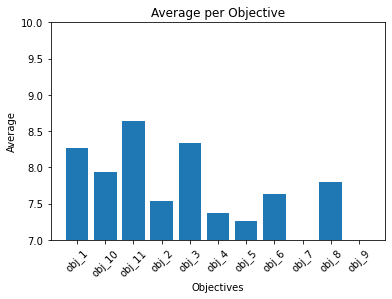

In [123]:
#gpt-4
scores_per_item, scores_per_objective, df = process_new_data(data_1,idx_cot=3,dataset='med_qa',split='test')
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
avg_true_false(data_1,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

In [117]:
#absolute_path = "./input_system/system_template_21.yaml"
data_2 = data_2.select(split="test", number_samples=30, random_samples=True, seed=0)
system_evaluate(data_2,'gpt-4',absolute_path)
data_2.dump("ob_template_18_gpt4")

Generating open_book_qa...


  0%|          | 0/30 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [172]:
#template 18 did not work with formatting
data = Collection.from_json("ob_template_18_gpt4")
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
#avg_true_false(cohere_false,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

Reusing dataset med_qa_dataset (/Users/robertpraas/.cache/huggingface/datasets/med_qa_dataset/thoughtsource/1.0.0/80feaf4e24940034debbd30deb9eeac25df0c6d1dfe2d8fb0cb497c9f549a35c)


Loading med_qa...


  0%|          | 0/3 [00:00<?, ?it/s]

wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found


KeyboardInterrupt: 

## System experiment

In [ ]:
#system experiment
#rate error!!

path = "./input_system/system_template_17.yaml"
data = Collection.load_thoughtsource_100(names = ['medmc_qa'],load_pregenerated_cots=False)
system_experiment(data,'gpt-3.5-turbo', path)
data.dump("medmc_template_17")


In [ ]:
gpt_4_test = Collection.from_json("/Users/robertpraas/Desktop/ThoughtSource/notebooks/internal_documentation/paper_2/filtered_thoughtsource_100_gpt-4_None_false.json")
gpt_4_test

## TO run

In [ ]:
# Can GPT-4 improve GPT-3.5?

#best candidates templ 15, (18) 20 (21)

# If so, how can GPT-4 help itself?
# What can we do with the objectives? look at obj scores of true and false

In [184]:
medqa_data = Collection.from_json("med_qa_zhou_eval.json")
ob_data = Collection.from_json("medmc_zhou_eval_chatgpt.json")
medmc_data = Collection.from_json("openbook_zhou_eval_chatgpt.json")



In [185]:
medqa_data = medqa_data.select(split="test", number_samples=30, random_samples=False, seed=0)
absolute_path = "./input_system/system_template_15_eval.yaml"
system_evaluate(medqa_data,'gpt-4',absolute_path)


Generating med_qa...


  0%|          | 0/30 [00:00<?, ?ex/s]

In [245]:
scores_per_item, variables_per_item, statements = parse_lst_data(medqa_data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item

wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found


[{'obj_1': 10,
  'obj_2': 10,
  'obj_3': 9,
  'obj_4': 10,
  'obj_5': 10,
  'obj_6': 10,
  'obj_7': 10,
  'obj_8': 10,
  'obj_9': 8,
  'obj_10': 10,
  'obj_11': 10},
 {'obj_1': 10,
  'obj_2': 10,
  'obj_3': 10,
  'obj_4': 10,
  'obj_5': 10,
  'obj_6': 10,
  'obj_7': 10,
  'obj_8': None},
 {'obj_1': 10,
  'obj_2': 10,
  'obj_3': 'N/A',
  'obj_4': 10,
  'obj_5': 10,
  'obj_6': 10,
  'obj_7': 10,
  'obj_8': 10,
  'obj_9': 8,
  'obj_10': 10,
  'obj_11': 10},
 {'obj_1': 10,
  'obj_2': 10,
  'obj_3': 10,
  'obj_4': 10,
  'obj_5': 10,
  'obj_6': 10,
  'obj_7': 9,
  'obj_8': 10,
  'obj_9': 10,
  'obj_10': 10,
  'obj_11': 10},
 {'obj_1': 10,
  'obj_2': 10,
  'obj_3': 10,
  'obj_4': 10,
  'obj_5': 10,
  'obj_6': 10,
  'obj_7': 9,
  'obj_8': 10,
  'obj_9': 10,
  'obj_10': 10,
  'obj_11': 10},
 {'obj_1': 10,
  'obj_2': 10,
  'obj_3': 9,
  'obj_4': 10,
  'obj_5': 10,
  'obj_6': 10,
  'obj_7': 9,
  'obj_8': 10,
  'obj_9': 10,
  'obj_10': 10,
  'obj_11': 10},
 {'obj_1': 10,
  'obj_2': 10,
  'obj_3': 

In [ ]:
scores_per_item, variables_per_item, statements = parse_lst_data(medqa_data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item

wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found


[{'obj_1': 10,
  'obj_2': 10,
  'obj_3': 9,
  'obj_4': 10,
  'obj_5': 10,
  'obj_6': 10,
  'obj_7': 10,
  'obj_8': 10,
  'obj_9': 8,
  'obj_10': 10,
  'obj_11': 10},
 {'obj_1': 10,
  'obj_2': 10,
  'obj_3': 10,
  'obj_4': 10,
  'obj_5': 10,
  'obj_6': 10,
  'obj_7': 10,
  'obj_8': None},
 {'obj_1': 10,
  'obj_2': 10,
  'obj_3': 'N/A',
  'obj_4': 10,
  'obj_5': 10,
  'obj_6': 10,
  'obj_7': 10,
  'obj_8': 10,
  'obj_9': 8,
  'obj_10': 10,
  'obj_11': 10},
 {'obj_1': 10,
  'obj_2': 10,
  'obj_3': 10,
  'obj_4': 10,
  'obj_5': 10,
  'obj_6': 10,
  'obj_7': 9,
  'obj_8': 10,
  'obj_9': 10,
  'obj_10': 10,
  'obj_11': 10},
 {'obj_1': 10,
  'obj_2': 10,
  'obj_3': 10,
  'obj_4': 10,
  'obj_5': 10,
  'obj_6': 10,
  'obj_7': 9,
  'obj_8': 10,
  'obj_9': 10,
  'obj_10': 10,
  'obj_11': 10},
 {'obj_1': 10,
  'obj_2': 10,
  'obj_3': 9,
  'obj_4': 10,
  'obj_5': 10,
  'obj_6': 10,
  'obj_7': 9,
  'obj_8': 10,
  'obj_9': 10,
  'obj_10': 10,
  'obj_11': 10},
 {'obj_1': 10,
  'obj_2': 10,
  'obj_3': 

In [238]:
scores_per_item, variables_per_item, statements = parse_lst_data(medqa_data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
avg_true_false(medqa_data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

wrong output found
wrong output found
wrong output found


TypeError: unsupported operand type(s) for +: 'int' and 'list'

In [239]:
scores_per_objective.items()

dict_items([('obj_9', [10, 8, 9, 8, 10, 8, 6, 9, 8, 7, 10, 9, 9, 9, 8, 6, 9, 9, 10, 9, 9, 7, 9, 9, 8, 9, 9, 8, 7, 8]), ('obj_2', [10, 8, 10, 9, 9, 8, 6, 10, 9, 8, 7, 9, 7, 7, 9, 7, 9, 10, 8, 10, 9, 9, 10, 10, 8, 10, 8, 7, 7, 9]), ('obj_3', [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 8, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10]), ('obj_8', [10, 8, 10, 10, 9, 7, 6, 10, 10, 9, 8, 6, 8, 7, 10, 7, 9, 10, 7, 10, 10, 9, 10, 10, 8, 10, 8, 7, 7, 10]), ('obj_4', [10, 8, 10, 9, 10, 8, 7, 10, 9, 8, 8, 8, 9, 7, 9, 8, 9, 10, 8, 10, 9, 8, 10, 10, 8, 10, 9, 8, 8, 9]), ('obj_1', [10, 9, 10, 10, 10, 9, 9, 10, 10, 9, 9, 9, 9, 8, 10, 9, 9, 10, 9, 10, 10, 8, 10, 10, 9, 10, 9, 9, 9, 10]), ('obj_6', [10, 9, 10, 9, 10, 8, 7, 10, 9, 9, 7, 9, 8, 8, 9, 7, 9, 10, 8, 10, 9, 9, 10, 10, 8, 10, 9, 7, 8, 9]), ('obj_10', [10, 7, 10, 10, 10, 8, 6, 10, 9, 8, 10, 9, 9, 9, 10, 7, 8, 10, 9, 10, 9, 8, 10, 10, 9, 10, 8, 8, 8, 9]), ('obj_11', [10, 9, 10, 10, 10, 7, 6, 10, 10, 10, 10, 4, 10, 5, 10, 

In [231]:
scores_per_item[0] #['obj_1'][1]

{'obj_1': ['The response interprets the question accurately and identifies the key information needed to answer the question.',
  10],
 'obj_2': ['The response considers relevant information from the question and avoids considering irrelevant information.',
  10],
 'obj_3': ['The response does not involve numerical information, so this objective is not applicable.',
  'N/A'],
 'obj_4': ['The response considers the relevant reasoning strategies by comparing the characteristics of the immune cells and selecting the most appropriate one.',
  10],
 'obj_5': ['The reasoning in the response is structured by comparing the characteristics of the immune cells and providing a brief explanation for the chosen answer.',
  9],
 'obj_6': ['The response gives appropriate priorities to the characteristics of the immune cells and their ability to lyse abnormal cells without the need for opsonization, priming, or prior activation.',
  10],
 'obj_7': ['The response does not explicitly list underlying ass

In [186]:
absolute_path = "./input_system/system_template_20.yaml"
system_evaluate(medqa_data,'gpt-4',absolute_path)

Generating med_qa...


  0%|          | 0/30 [00:00<?, ?ex/s]

In [207]:
medqa_data['med_qa']['test'][2]['generated_cot'][2]['cot']

'critique: The response accurately interprets the question, considers relevant information, and provides a well-structured reasoning. The final answer is based on the reasoning and corresponds to one of the answer options.\nobj_1: 10\nobj_2: 10\nobj_3: 10\nobj_4: 10\nobj_5: 10\nobj_6: 10\nobj_7: 9\nobj_8: 10\nobj_9: 9\nobj_10: 10\nobj_11: 10'

In [212]:
medqa_data.evaluate()

  0%|          | 0/30 [00:00<?, ?ex/s]

{'med_qa': {'test': {'accuracy': {'': {'__': 0.0},
    'gpt-3.5-turbo': {'None_zhou-01_kojima-A-E': 0.7}}}}}

         Average
obj_1   9.500000
obj_2   8.966667
obj_3   9.566667
obj_4   8.800000
obj_5   9.166667
obj_6   8.866667
obj_7   8.000000
obj_8   8.966667
obj_9   8.233333
obj_10  9.033333
obj_11  9.033333
scores true: 9.333333333333334
scores false: 7.95959595959596


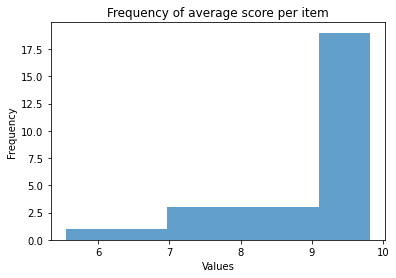

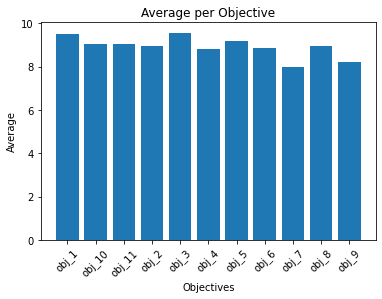

In [214]:
scores_per_item, variables_per_item = parse_data(medqa_data,idx_cot=2,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
avg_true_false(medqa_data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

In [187]:
medqa_data.dump("medqa_4_on_3_template_15_20")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [188]:
ob_data = ob_data.select(split="test", number_samples=30, random_samples=False, seed=0)
absolute_path = "./input_system/system_template_15_eval.yaml"
system_evaluate(ob_data,'gpt-4',absolute_path)

In [189]:
absolute_path = "./input_system/system_template_20.yaml"
system_evaluate(ob_data,'gpt-4',absolute_path)

In [222]:
#what happened?

| Name         | Train   | Valid   |   Test |
|--------------|---------|---------|--------|
| open_book_qa | -       | -       |     30 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [ ]:
scores_per_item, variables_per_item = parse_data(ob_data,idx_cot=2,dataset='open_book_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
avg_true_false(medqa_data,average_per_item,'open_book_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

In [190]:
ob_data.dump("ob_4_on_3_template_15_20")

In [191]:
medmc_data = medmc_data.select(split="test", number_samples=30, random_samples=False, seed=0)
absolute_path = "./input_system/system_template_15_eval.yaml"
system_evaluate(medmc_data,'gpt-4',absolute_path)

Generating open_book_qa...


  0%|          | 0/30 [00:00<?, ?ex/s]

In [192]:
absolute_path = "./input_system/system_template_20.yaml"
system_evaluate(medmc_data,'gpt-4',absolute_path)

Generating open_book_qa...


  0%|          | 0/30 [00:00<?, ?ex/s]

(API-)Error in item 7: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Tue, 30 May 2023 16:38:29 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7cf867e97d00c316-VIE', 'alt-svc': 'h3=":443"; ma=86400'}
Retrying with additional time of 10 seconds.
(API-)Error in item 18: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Tue, 30 May 2023 16:49:44 GMT', 'Content-Type': 'application/json', 'Con

In [225]:
medmc_data

| Name         | Train   | Valid   |   Test |
|--------------|---------|---------|--------|
| open_book_qa | -       | -       |     30 |
| medmc_qa     | 182822  | 4183    |   6150 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa', 'med_qa_open', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

         Average
obj_1   9.400000
obj_2   8.566667
obj_3   9.833333
obj_4   8.800000
obj_5   9.266667
obj_6   8.833333
obj_7   7.766667
obj_8   8.666667
obj_9   8.466667
obj_10  8.933333
obj_11  8.966667
scores true: 9.024793388429751
scores false: 8.420454545454545


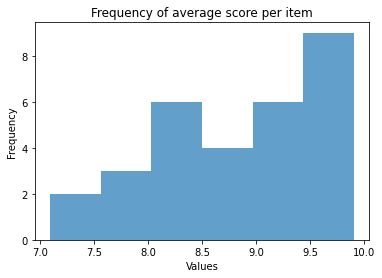

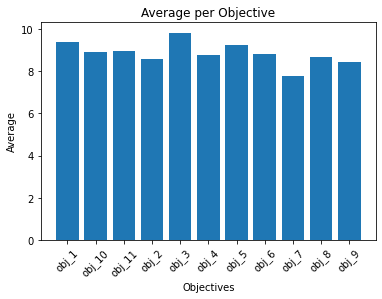

In [227]:
scores_per_item, variables_per_item = parse_data(medmc_data,idx_cot=2,dataset='open_book_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
avg_true_false(medmc_data,average_per_item,'open_book_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

In [193]:
medmc_data.dump("medmc_4_on_3_template_15_20")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [229]:
scores_per_item, variables_per_item, statements = parse_lst_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
#avg_true_false(cohere_false,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

wrong output found
wrong output found


TypeError: unsupported operand type(s) for +: 'int' and 'list'

In [ ]:
#fix this
data_2 = Collection.from_json("openbook_zhou_eval_chatgpt.json")

absolute_path = "./input_system/system_template_21.yaml"
data_2 = data_2.select(split="test", number_samples=30, random_samples=True, seed=0)
system_evaluate(data_2,'gpt-4',absolute_path)
data_2.dump("ob_template_18_gpt4")

system_evaluate(data,'gpt-3.5-turbo',absolute_path)
data.dump("ob_template_21")

In [ ]:
#Data:
Collection.from_json("med_qa_zhou_cohere.json")
Collection.from_json("openbook_zhou_eval_chatgpt.json")
Collection.from_json("medmc_zhou_eval_chatgpt.json")

# Can we improve accuracy?
"""fix system_experiment api error for this"""
system_template_19.yaml --> run reasoning and then score #17 vs 19

# TODO
# give a final grade
# Experiment if this goes well and then add
